# COGS 118B Final Project
## Taiko no Tatsujin Chart Difficulty Classification

**Contributers:** Miles Davis, Theo Bui, Alan De Luna, Sanjith Shanmugavel, Nicole Huynh

#### Abstract

Taiko no Tatsujin is a popular Japanese rhythm game where players hit drum notes in rhythm with music. While the game assigns difficulty ratings to songs on a scale from 1 to 10, the underlying factors that determine these ratings are not well3
understood. In this work, we apply machine learning to predict chart difficulty directly from features extracted from .tja game files. Using a Random Forest Regressor trained on over 7,000 chart courses, we achieve an R2 of 0.854 and a within-±1 accuracy of 93.36%. Our analysis reveals that note count features dominate difficulty prediction, accounting for over 50% of feature importance. To our knowledge, this is the first application of machine learning to Taiko no Tatsujin ifficulty classification, extending prior work on rhythm game analysis to a new domain.

#### Algorithm Choice
For our classifier, we chose a Random Forest regressor based on its versatility and flexibility with missing or inconsistent data, for which we found some during our data preprocessing. The input to the classifier are feature vectors containing each chart and its derived features, and the goal is to classify a different level (1 through 10 stars) within a specific difficulty range (Easy, Normal, Hard, Oni).

#### Data Preprocessing
1. read in `.tja` files line-by-line as strings
2. convert strings to numpy arrays representing sequence of notes
3. extract relevant information

Metadata:
- `BPM`
- `OFFSET`
- `GENRE`

Course info:
- `COURSE`
- `LEVEL`
- `BALLOON`
- song notation: written between `#START` and `#END` commands
- timing notation:- `#MEASURE` and `#BPMCHANGE`
    - from Taiko explanation: 'Measures in the chart are separated with a comma character, followed by a line break. Timing between each measure is the same as long as #MEASURE and #BPMCHANGE commands are not used. Measures may contain any amount of notes, including zero, the less numbers there are in a measure, the more far apart the notes will be in the chart, each measure is equally divided by the amount of numbers there are inside. "12," can be written as "1020," and "10002000,", the timing is identical in all three examples.'
- delay: offsets position of following notation (can be negative to indicate overlap) and written as `#DELAY`
- scroll speed: `#SCROLL`
- Go-Go Time: written between `#GOGOSTART` and `#GOGOEND`
- measure lines turned on/off: `#BARLINEOFF` and `#BARLINEON`
- branching and paths: `#BRANCHSTART`
    - branches represent different "paths" within a chart that a player can take based on accuracy, hit notes, or other factors, with the "Normal" branch typically being the easiest and the "Master" branch being the hardest. For our purposes, we limit our discussion to charts including the "Master" branch.
- BPM changes: includes changes from initial bpm to first `#BPMCHANGE` and subsequent `#BPMCHANGE`s

In [17]:
import numpy as np
import pandas as pd
import os

# Basic flow for loading and processing charts

## Reading in chart data

In [24]:
# load one .tja file as a test
test_path = 'test_data/cruel_angels_thesis.tja'

try:
    with open(test_path, 'r', encoding='utf-8') as file:
        test_str = file.read()
except FileNotFoundError:
    print('file not found :-(')
except Exception as e:
    print(f'an error occurred: {e}')

In [25]:
print(test_str)

//TJADB Project
TITLE:A Cruel Angel's Thesis -New Audio-
TITLEJA:残酷な天使のテーゼ -新曲-
SUBTITLE:--Youko Takahashi/Neon Genesis Evangelion
BPM:80
WAVE:A Cruel Angels Thesis -New Audio-.ogg
OFFSET:-5.041
DEMOSTART:68.079

COURSE:Edit
LEVEL:8
SCOREINIT:740
SCOREDIFF:208


#START


,
#BPMCHANGE 79
1000100010010010,
#MEASURE 8/4
#BPMCHANGE 76.7
100000000000100000000000100000000000500000000000
#BPMCHANGE 134
000000000000000000000000000000000008000000000000,
#MEASURE 4/4
#BPMCHANGE 129
1010210121012010,
1010210121020000,
1010210121012010,
1010221030040000,
1010201012102000,
1010201012102000,
1120212011202120,
1120221010000000,
1120201010222000,
1120201010222000,
1020102010222010,
1020102022102210,
1020102010221020,
1020102010221020,
1120221011202210,
1120221010222000,
1010221022221000,
1010221022221000,
1020122010201220,
1101210121012102,
1101102012022020,
1120221011202210,
1101201011012010,
1212,
1101102011011020,
1220122011122020,
1121102011211010,
3000000030030030,

#GOGOSTART
#SECTION
#BRANCHSTA

In [26]:
# split string by lines
chart = test_str.split('COURSE:')
len(chart)

6

In [27]:
chart

["\ufeff//TJADB Project\nTITLE:A Cruel Angel's Thesis -New Audio-\nTITLEJA:残酷な天使のテーゼ -新曲-\nSUBTITLE:--Youko Takahashi/Neon Genesis Evangelion\nBPM:80\nWAVE:A Cruel Angels Thesis -New Audio-.ogg\nOFFSET:-5.041\nDEMOSTART:68.079\n\n",
 'Edit\nLEVEL:8\nSCOREINIT:740\nSCOREDIFF:208\n\n\n#START\n\n\n,\n#BPMCHANGE 79\n1000100010010010,\n#MEASURE 8/4\n#BPMCHANGE 76.7\n100000000000100000000000100000000000500000000000\n#BPMCHANGE 134\n000000000000000000000000000000000008000000000000,\n#MEASURE 4/4\n#BPMCHANGE 129\n1010210121012010,\n1010210121020000,\n1010210121012010,\n1010221030040000,\n1010201012102000,\n1010201012102000,\n1120212011202120,\n1120221010000000,\n1120201010222000,\n1120201010222000,\n1020102010222010,\n1020102022102210,\n1020102010221020,\n1020102010221020,\n1120221011202210,\n1120221010222000,\n1010221022221000,\n1010221022221000,\n1020122010201220,\n1101210121012102,\n1101102012022020,\n1120221011202210,\n1101201011012010,\n1212,\n1101102011011020,\n1220122011122020,\n1121102

## Splitting different difficulties of charts into separate data points

In [28]:
# try to grab just relevant info listed above

# metadata for entire song chart
metadata = chart[0].split('\n')
bpm = int(metadata[4][4:])
offset = float(metadata[6][7:])

# courses by difficulty
edit = [i for i in chart if 'Edit' in i]
oni = [i for i in chart if 'Oni' in i]
hard = [i for i in chart if 'Hard' in i]
normal = [i for i in chart if 'Normal' in i]
easy = [i for i in chart if 'Easy' in i]

In [29]:
course_diff = {'Easy': 0, 'Normal': 1, 'Hard': 2, 'Oni': 3, 'Edit': 4, 'Tower': 5, 'Dan': 6}
lvl_diff = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [30]:
int([i[6:] for i in normal[0].split('\n') if 'LEVEL' in i][0])

4

In [ ]:
normal

['Normal\nLEVEL:4\nSCOREINIT:1310\nSCOREDIFF:420\n\n\n#START\n\n\n1,\n#BPMCHANGE 79\n1,\n#BPMCHANGE 76.7\n#MEASURE 8/4\n100000000000100000000000500000000000000000000000\n#BPMCHANGE 134\n000000000000000000000008000000000000000000000000,\n#MEASURE 4/4\n#BPMCHANGE 129\n1110,\n11102000,\n1110,\n1010100030030000,\n1120,\n1120,\n11,\n12,\n10011020,\n10022000,\n10011020,\n10022000,\n1120,\n1120,\n11,\n12,\n10011020,\n10022000,\n10011020,\n500000000000000000000000000008000000000000000000,\n1001000010000000,\n2002000020000000,\n1001000010000000,\n1,\n1001000010000000,\n2002000020000000,\n1001000010000000,\n500000000000000000000000000008000000000000000000,\n\n#GOGOSTART\n1000100010010000,\n1000000020020000,\n1110,\n1000100020020000,\n1000100010010000,\n1000000020020000,\n1110,\n1000100030030000,\n1000100010010000,\n1000000020020000,\n1110,\n1000100030030000,\n\n#GOGOEND\n\n\n#END\n\n\n']

## Chart decomposition into obvious features

In [34]:
# complete course and measures
normal_full = normal[0].split('#START')[1]
normal_full = normal_full.split('#END')[0].split('\n')
all_measures = [i[:-1] for i in normal_full if ',' in i]

# just go-go time part of course and measures
gogo_time_idx = [
    i for i, val in enumerate(normal_full)
    if val in ('#GOGOSTART', '#GOGOEND')
]
gogo_time = normal_full[gogo_time_idx[0]:gogo_time_idx[1]+1]
gogo_time_measures = [i[:-1] for i in gogo_time if ',' in i]

# just non go-go time part of course and measures
reg_time = normal_full[:gogo_time_idx[0]] + normal_full[gogo_time_idx[1]+1:]
reg_measures = [i[:-1] for i in reg_time if ',' in i]

# every bpm and measure change
# but also taking note of what bpm/time sig the course is being changed to would also be valuable
bpm_change = [i for i in normal_full if '#BPMCHANGE' in i]
measure_change = [i for i in normal_full if '#MEASURE' in i]

# change gogo_time_idx to list of normal_full indices
gogo_time_idx = [i for i in range(gogo_time_idx[0], gogo_time_idx[1]+1)]
reg_time_idx = [i for i in range(len(normal_full)) if i not in gogo_time_idx]

In [35]:
normal_course = {
    'full_chart': normal_full,
    'all_measures': all_measures,
    'full_gogo_chart': gogo_time,
    'gogo_time_measures': gogo_time_measures,
    'gogo_time_indices': gogo_time_idx,
    'full_non_gogo_chart': reg_time,
    'non_gogo_measures': reg_measures,
    'non_gogo_indices': reg_time_idx,
    'all_bpm_changes': bpm_change,
    'all_time_sig_changes': measure_change
}

In [36]:
gogo_time_measures_copy = [i for i in gogo_time_measures]
gogo_time_measures_copy[2] = '1000100010000000'
gogo_time_measures_copy[6] = '1000100010000000'
gogo_time_measures_copy[10] = '1000100010000000'

In [13]:
gogo_time_measures_copy

['1000100010010000',
 '1000000020020000',
 '1000100010000000',
 '1000100020020000',
 '1000100010010000',
 '1000000020020000',
 '1000100010000000',
 '1000100030030000',
 '1000100010010000',
 '1000000020020000',
 '1000100010000000',
 '1000100030030000']

In [14]:
len('1000100010000000')

16

In [15]:
print(np.array(normal_course))

{'full_chart': ['', '', '', '1,', '#BPMCHANGE 79', '1,', '#BPMCHANGE 76.7', '#MEASURE 8/4', '100000000000100000000000500000000000000000000000', '#BPMCHANGE 134', '000000000000000000000008000000000000000000000000,', '#MEASURE 4/4', '#BPMCHANGE 129', '1110,', '11102000,', '1110,', '1010100030030000,', '1120,', '1120,', '11,', '12,', '10011020,', '10022000,', '10011020,', '10022000,', '1120,', '1120,', '11,', '12,', '10011020,', '10022000,', '10011020,', '500000000000000000000000000008000000000000000000,', '1001000010000000,', '2002000020000000,', '1001000010000000,', '1,', '1001000010000000,', '2002000020000000,', '1001000010000000,', '500000000000000000000000000008000000000000000000,', '', '#GOGOSTART', '1000100010010000,', '1000000020020000,', '1110,', '1000100020020000,', '1000100010010000,', '1000000020020000,', '1110,', '1000100030030000,', '1000100010010000,', '1000000020020000,', '1110,', '1000100030030000,', '', '#GOGOEND', '', '', ''], 'all_measures': ['1', '1', '000000000000000

In [16]:
list('1110')

['1', '1', '1', '0']

## Additional data cleaning

In [ ]:
def format_measures(measures, max_len):
    '''Formats measures consistently (i.e., inserts spacing with additional 0's) based on the maximum length of a measure in a chart.'''
    new_measures = [i for i in measures]
    
    for i in range(len(measures)):
        if len(measures[i]) == 0:
            new_measures[i] = max_len*'0'
        elif len(measures[i]) != max_len:
            zeroes = int((max_len / len(measures[i])) - 1)
            reformat = [i + zeroes*'0' for i in list(measures[i])]
            new_measures[i] = ''.join(reformat)
    
    return new_measures

In [ ]:
def handle_branches(chart_lines):
    '''Handles divergent charts with branching paths by only considering the measures associated with the hardest path in the song.'''
    has_branch = any('#BRANCHSTART' in line for line in chart_lines)
    if not has_branch:
        return chart_lines
    
    result = []
    in_branch = False
    current_branch = None
    branch_content = {'N': [], 'E': [], 'M': []}
    
    for line in chart_lines:
        stripped = line.strip()
        
        if stripped.startswith('#BRANCHSTART'):
            in_branch = True
            branch_content = {'N': [], 'E': [], 'M': []}
            current_branch = None
            continue
            
        elif stripped == '#N':
            current_branch = 'N'
            continue
            
        elif stripped == '#E':
            current_branch = 'E'
            continue
            
        elif stripped == '#M':
            current_branch = 'M'
            continue
            
        elif stripped == '#BRANCHEND':
            # Just picking M if possible and if not cycle through E and then N
            if branch_content['M']:
                result.extend(branch_content['M'])
            elif branch_content['E']:
                result.extend(branch_content['E'])
            elif branch_content['N']:
                result.extend(branch_content['N'])
            
            in_branch = False
            current_branch = None
            continue
        
        if in_branch and current_branch:
            branch_content[current_branch].append(line)
        elif not in_branch:
            result.append(line)
    
    return result

# Dataset preprocessing and feature extraction

## Helper functions for extraction

In [ ]:
def extract_info(course):
    difficulty = course[0].split('\n')[0]
    level = int([i[6:] for i in course[0].split('\n') if 'LEVEL:' in i][0])
    
    # complete course and measures
    full_course = course[0].split('#START')[1]
    full_course = full_course.split('#END')[0].split('\n')

    full_course = handle_branches(full_course)


    all_measures = [i[:-1] for i in full_course if ',' in i]
    max_measure_len = len(max(all_measures, key=len))
    all_measures = format_measures(all_measures, max_measure_len)

    # just go-go time part of course and measures
    gogo_time_idx = [
        i for i, val in enumerate(full_course)
        if val in ('#GOGOSTART', '#GOGOEND')
    ]
    gogo_time = full_course[gogo_time_idx[0]:gogo_time_idx[1]+1]
    gogo_time_measures = format_measures([i[:-1] for i in gogo_time if ',' in i], max_measure_len)

    # just non go-go time part of course and measures
    reg_time = full_course[:gogo_time_idx[0]] + full_course[gogo_time_idx[1]+1:]
    reg_measures = format_measures([i[:-1] for i in reg_time if ',' in i], max_measure_len)

    # every bpm and measure change
    # but also taking note of what bpm/time sig the course is being changed to would also be valuable
    bpm_change = [i for i in full_course if '#BPMCHANGE' in i]
    measure_change = [i for i in full_course if '#MEASURE' in i]

    # change gogo_time_idx to list of full_course indices
    gogo_time_idx = [i for i in range(gogo_time_idx[0], gogo_time_idx[1]+1)]
    reg_time_idx = [i for i in range(len(full_course)) if i not in gogo_time_idx]

    course_arr = {
        'course_difficulty': difficulty,
        'course_level': level,
        'full_course_chart': full_course,
        'all_measures': all_measures,
        'full_gogo_chart': gogo_time,
        'gogo_time_measures': gogo_time_measures,
        'gogo_time_indices': gogo_time_idx,
        'full_non_gogo_chart': reg_time,
        'non_gogo_measures': reg_measures,
        'non_gogo_indices': reg_time_idx,
        'all_bpm_changes': bpm_change,
        'all_time_sig_changes': measure_change
    }

    return course_arr

In [39]:
def extract_all_courses(chart):
    metadata = chart[0].split('\n')
    bpm = int([i[4:] for i in metadata if 'BPM:' in i][0])
    offset = float([i[7:] for i in metadata if 'OFFSET:' in i][0])
    
    edit = [i for i in chart if 'Edit' in i]
    oni = [i for i in chart if 'Oni' in i]
    hard = [i for i in chart if 'Hard' in i]
    normal = [i for i in chart if 'Normal' in i]
    easy = [i for i in chart if 'Easy' in i]

    all_diff = [easy, normal, hard, oni, edit]
    all_extracted = []

    for d in all_diff:
        all_extracted.append(extract_info(d))

    return all_extracted + [bpm] + [offset]

In [148]:
extract_all_courses(chart)

[{'course_difficulty': 'Easy',
  'course_level': 4,
  'full_course_chart': ['',
   '',
   '',
   '1,',
   '#BPMCHANGE 79',
   '1,',
   '#BPMCHANGE 76.7',
   '#MEASURE 8/4',
   '100000000000100000000000500000000000000000000000',
   '#BPMCHANGE 134',
   '000000000000000000000000000000000008000000000000,',
   '#MEASURE 4/4',
   '#BPMCHANGE 129',
   '12,',
   '1120,',
   '11,',
   '1000100030030000,',
   '11,',
   '12,',
   '11,',
   '12,',
   '10011000,',
   '10022000,',
   '1012,',
   '10022000,',
   '11,',
   '12,',
   '11,',
   '12,',
   '10011000,',
   '10022000,',
   '1111,',
   '500000000000000000000000000000000008000000000000,',
   '1001000000000000,',
   '2002000000000000,',
   '12,',
   '12,',
   '1001000000000000,',
   '2002000000000000,',
   '11,',
   '500000000000000000000000000000000008000000000000,',
   '',
   '#GOGOSTART',
   '1110,',
   '1220,',
   '1110,',
   '1120,',
   '1110,',
   '1220,',
   '1110,',
   '1000000030030000,',
   '1110,',
   '1220,',
   '1110,',
   '10000

In [ ]:
def extract_note_features(measures):
    """Extract numerical features from note patterns"""
    
    # Concatenate all measures into one sequence
    full_sequence = ''.join(measures)
    
    features = {}
    
    # Basic note counts
    features['total_notes'] = sum(1 for c in full_sequence if c in '1234')
    features['don_notes'] = full_sequence.count('1')  # Red notes (center)
    features['ka_notes'] = full_sequence.count('2')   # Blue notes (rim)
    features['big_don'] = full_sequence.count('3')    # Big red
    features['big_ka'] = full_sequence.count('4')     # Big blue
    features['drumroll'] = full_sequence.count('5')   # Yellow drumrolls
    features['balloon'] = full_sequence.count('6')    # Balloons
    
    # Note density (notes per measure)
    features['note_density'] = features['total_notes'] / len(measures) if measures else 0
    
    # Pattern complexity metrics
    features['note_variety'] = len(set(c for c in full_sequence if c in '123456'))
    
    # Calculate note spacing (average zeros between notes)
    note_positions = [i for i, c in enumerate(full_sequence) if c in '1234']
    if len(note_positions) > 1:
        spacings = [note_positions[i+1] - note_positions[i] 
                   for i in range(len(note_positions)-1)]
        features['avg_spacing'] = np.mean(spacings)
        features['min_spacing'] = np.min(spacings)
        features['spacing_variance'] = np.var(spacings)
    else:
        features['avg_spacing'] = 0
        features['min_spacing'] = 0
        features['spacing_variance'] = 0
    
    # Pattern transitions (how often notes change type)
    transitions = sum(1 for i in range(len(note_positions)-1) 
                     if full_sequence[note_positions[i]] != full_sequence[note_positions[i+1]])
    features['transition_rate'] = transitions / len(note_positions) if note_positions else 0
    
    return features


def extract_timing_features(course_data, init_bpm):
    """Extract features from BPM and timing changes"""
    
    features = {}
    
    # Count timing changes
    features['bpm_changes'] = len(course_data['all_bpm_changes'])
    features['time_sig_changes'] = len(course_data['all_time_sig_changes'])
    
    # Extract BPM values
    bpm_values = [init_bpm]
    for change in course_data['all_bpm_changes']:
        bpm = float(change.split()[1])
        bpm_values.append(bpm)
    
    if bpm_values:
        features['max_bpm'] = max(bpm_values)
        features['min_bpm'] = min(bpm_values)
        features['avg_bpm'] = np.mean(bpm_values)
        features['bpm_variance'] = np.var(bpm_values)
    else:
        features['max_bpm'] = 0
        features['min_bpm'] = 0
        features['avg_bpm'] = 0
        features['bpm_variance'] = 0
    
    return features


def extract_gogo_features(course_data):
    """Extract features from Go-Go Time sections"""
    
    features = {}
    
    gogo_measures = course_data['gogo_time_measures']
    all_measures = course_data['all_measures']
    
    # Proportion of chart in go-go time
    features['gogo_proportion'] = len(gogo_measures) / len(all_measures) if all_measures else 0
    
    # Note density in go-go vs regular sections
    gogo_notes = sum(sum(1 for c in m if c in '1234') for m in gogo_measures)
    regular_measures = course_data['non_gogo_measures']
    regular_notes = sum(sum(1 for c in m if c in '1234') for m in regular_measures)
    
    features['gogo_note_density'] = gogo_notes / len(gogo_measures) if gogo_measures else 0
    features['regular_note_density'] = regular_notes / len(regular_measures) if regular_measures else 0
    
    return features


def create_feature_vector(course_data, init_bpm):
    """Combine all features into a single vector"""
    
    features = {}
    
    # Get all feature types
    note_features = extract_note_features(course_data['all_measures'])
    timing_features = extract_timing_features(course_data, init_bpm)
    gogo_features = extract_gogo_features(course_data)
    
    # Combine all features
    features.update(note_features)
    features.update(timing_features)
    features.update(gogo_features)
    
    # Add the target labels
    features['difficulty_name'] = course_data['course_difficulty']
    features['difficulty_level'] = course_data['course_level']
    
    return features

In [176]:
def process_all_charts(chart_directory):
    """Process all .tja files recursively into a training dataset"""
    
    all_features = []
    processed_count = 0
    error_count = 0
    
    
    for root, dirs, files in os.walk(chart_directory):
        for filename in files:
            if not filename.endswith('.tja'):
                continue
            
            filepath = os.path.join(root, filename)
            
            try:
                with open(filepath, 'r', encoding='utf-8') as file:
                    chart_str = file.read()
                
                # Extract BPM
                bpm_lines = [i[4:] for i in chart_str.split('\n') if 'BPM:' in i]
                if not bpm_lines:
                    print(f"Warning: No BPM found in {filepath}, skipping...")
                    continue
                    
                init_bpm = int(bpm_lines[0])
                
                # Parse the chart - split by COURSE:
                raw_courses = chart_str.split('COURSE:')[1:]
                
                clean_courses = []
                for course in raw_courses:
                    try:
                        clean_courses.append(extract_info([course]))
                    except Exception as e:
                        #There are a ton of errors LOL uncomment this if you wanna see
                        #print(f"Error extracting course from {filepath}: {e}")
                        continue
                
                # Process each difficulty
                for course_data in clean_courses:
                    features = create_feature_vector(course_data, init_bpm)
                    features['source_file'] = filepath  # Track which file it came from
                    all_features.append(features)
                
                processed_count += 1
                    
            except Exception as e:
                error_count += 1
                #More errors...
                #print(f"Error processing {filepath}: {e}")
                continue
    
    print(f"\n{'='*60}")
    print(f"Processing complete!")
    print(f"Successfully processed: {processed_count} files")
    print(f"Errors encountered: {error_count} files")
    print(f"Total courses extracted: {len(all_features)}")
    print(f"{'='*60}\n")
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features)
    
    return df

In [151]:
def extract_info_per_measure(chart_lines):
    for line in chart_lines:
        if line.startswith("COURSE:") or line.startswith("LEVEL:"):
            continue

    measures_arr = [
        [],  # 0: notes
        [],  # 1: bpm
        [],  # 2: time signature
        [],  # 3: scroll speed
        [],  # 4: is_gogo
    ]

    current_bpm = 0
    time_sig = (4, 4)
    scroll = 1.0
    is_gogo = False

    inside_chart = False
    current_measure_notes = ""

    for raw_line in chart_lines:
        line = raw_line.strip()

        if not line or line.startswith("//"):
            continue

        # chart boundaries
        if line.startswith("#START"):
            inside_chart = True
            continue

        if line.startswith("#END"):
            inside_chart = False
            break

        if not inside_chart:
            continue

        # measure metadata
        if line.startswith("#BPMCHANGE"):
            current_bpm = float(line.split()[1])
            continue

        if line.startswith("#MEASURE"):
            num, den = line.split()[1].split("/")
            time_sig = (int(num), int(den))
            continue

        if line.startswith("#SCROLL"):
            scroll = float(line.split()[1])
            continue

        if line == "#GOGOSTART":
            is_gogo = True
            continue

        if line == "#GOGOEND":
            is_gogo = False
            continue

        # measure content
        if "," in line:
            note_part = line.replace(",", "")
            current_measure_notes += note_part

            measures_arr[0].append(current_measure_notes)
            measures_arr[1].append(current_bpm)
            measures_arr[2].append(time_sig)
            measures_arr[3].append(scroll)
            measures_arr[4].append(1 if is_gogo else 0)

            current_measure_notes = ""
        else:
            current_measure_notes += line

    return np.array(measures_arr)

## Extracting features from entire dataset

In [178]:
# PROCESS THE CHARTS
df = process_all_charts('charts/')
print(f"\nProcessed {len(df)} courses")


print(f"\nDataFrame shape: {df.shape}")
print(f"\nDifficulty distribution:")
print(df['difficulty_name'].value_counts())
print(f"\nFirst few rows:")
print(df.head())

# Save to CSV
df.to_csv('taiko_features.csv', index=False)


Processing complete!
Successfully processed: 2528 files
Errors encountered: 427 files
Total courses extracted: 9234


Processed 9234 courses

DataFrame shape: (9234, 25)

Difficulty distribution:
difficulty_name
Hard           2187
Oni            2184
Easy           2165
Normal         2161
Edit            319
Dan              99
0                51
1                51
2                 7
Oni               2
3                 1
Normal            1
Oni               1
Hard              1
Edit              1
hard              1
normal            1
easy              1
Name: count, dtype: int64

First few rows:
   total_notes  don_notes  ka_notes  big_don  big_ka  drumroll  balloon  \
0          429        191       201       23      14         1        0   
1          353        173       144       23      13         2        0   
2          239        160        47       18      14         4        0   
3          121         70        11       28      12         5        2   
4        

In [180]:
df['difficulty_level'].mean()

np.float64(5.300194931773879)

# Classification model training

LOADING DATA

Original dataset shape: (9234, 25)
Columns: ['total_notes', 'don_notes', 'ka_notes', 'big_don', 'big_ka', 'drumroll', 'balloon', 'note_density', 'note_variety', 'avg_spacing', 'min_spacing', 'spacing_variance', 'transition_rate', 'bpm_changes', 'time_sig_changes', 'max_bpm', 'min_bpm', 'avg_bpm', 'bpm_variance', 'gogo_proportion', 'gogo_note_density', 'regular_note_density', 'difficulty_name', 'difficulty_level', 'source_file']

Missing values per column:
Series([], dtype: int64)

DATA CLEANING

Filtered to main difficulties: 8810 courses
Difficulty distribution:
difficulty_name
Easy      2217
Hard      2195
Normal    2213
Oni       2185
Name: count, dtype: int64

After removing outliers: 8810 courses

FEATURE ENGINEERING
Added 6 derived features
New feature count: 31

PREPARING FEATURES
Feature matrix shape: (8810, 28)
Target shape: (8810,)

Target distribution:
1      213
2      617
3     1332
4     1583
5     1444
6     1184
7     1116
8      800
9      302
10     219


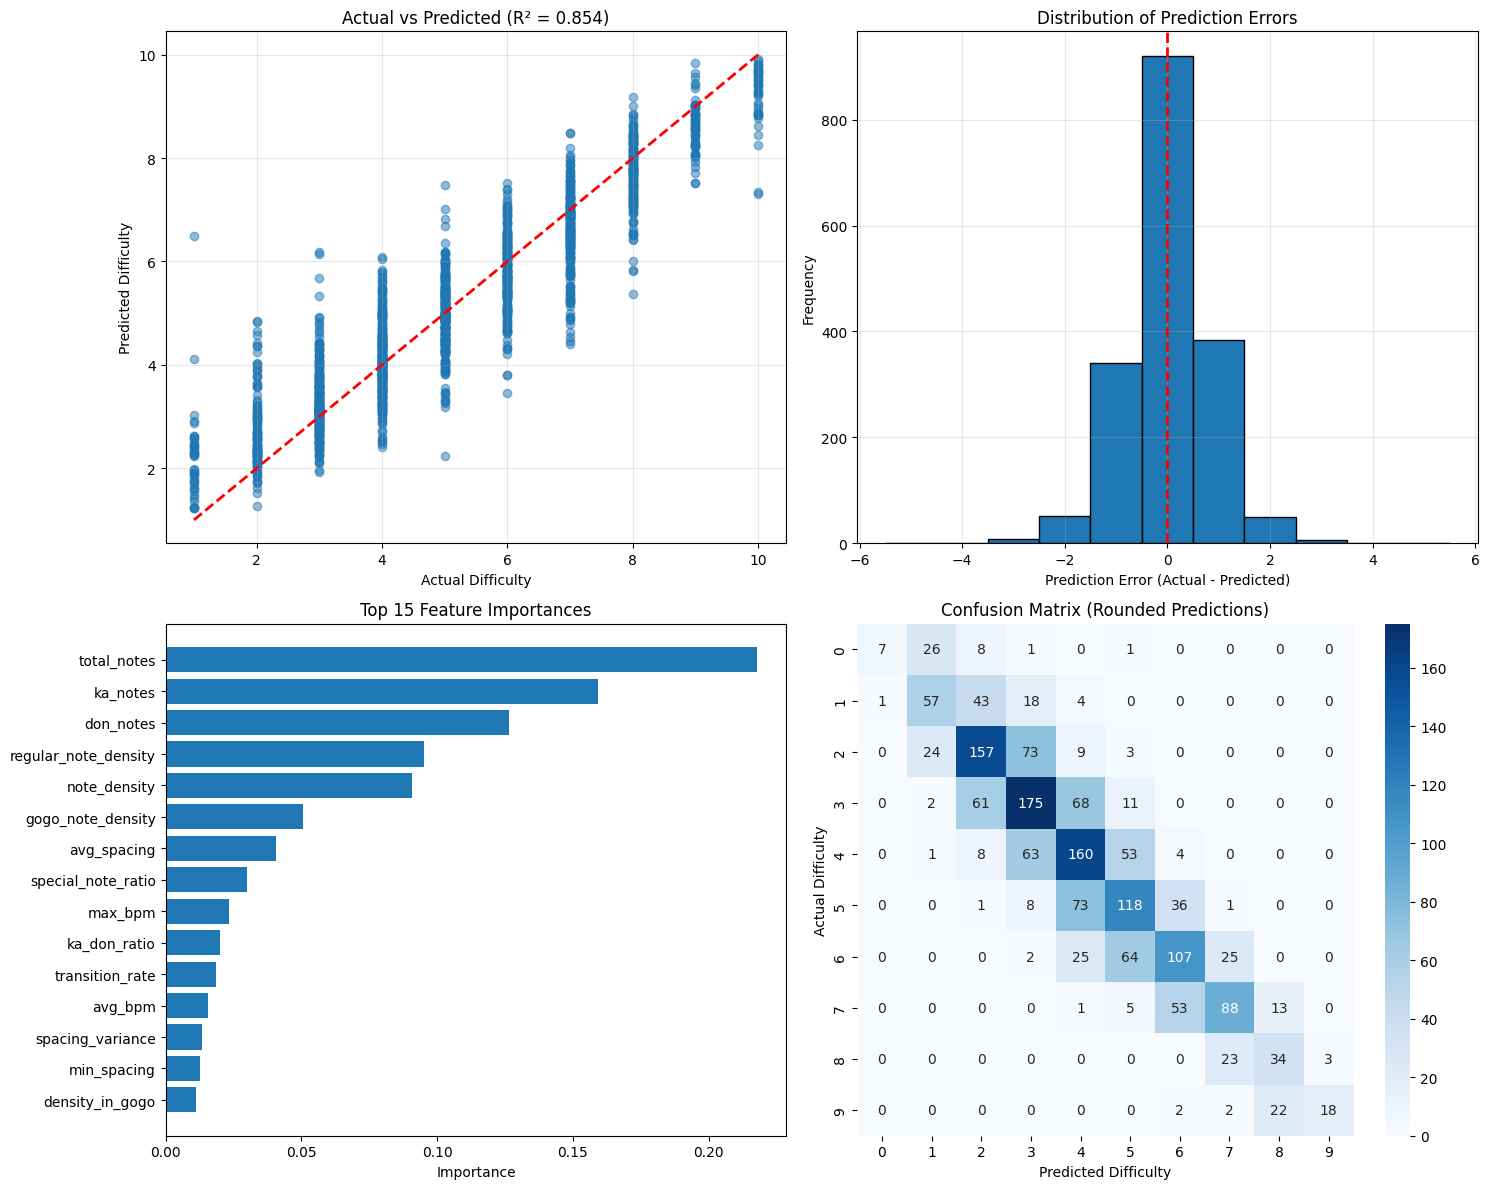

In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# ============================================================
# 1. LOAD AND CLEAN DATA
# ============================================================

print("="*60)
print("LOADING DATA")
print("="*60)

# Load the preprocessed features
df = pd.read_csv('taiko_features.csv')
print(f"\nOriginal dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Check for missing values
print(f"\nMissing values per column:")
print(df.isnull().sum()[df.isnull().sum() > 0])

# ============================================================
# 2. DATA CLEANING
# ============================================================

print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

# Clean difficulty_name column - standardize the labels
difficulty_mapping = {
    'Easy': 'Easy',
    'easy': 'Easy',
    'Normal': 'Normal',
    'normal': 'Normal',
    'Hard': 'Hard',
    'hard': 'Hard',
    'Oni': 'Oni',
    'oni': 'Oni',
    'Edit': 'Edit',
    'Dan': 'Dan',
    '0': 'Easy',
    '1': 'Normal',
    '2': 'Hard',
    '3': 'Oni',
}

# Apply mapping
df['difficulty_name'] = df['difficulty_name'].map(lambda x: difficulty_mapping.get(str(x), 'Unknown'))

# Filter to main difficulty levels (remove Dan, Edit, Unknown)
main_difficulties = ['Easy', 'Normal', 'Hard', 'Oni']
df_clean = df[df['difficulty_name'].isin(main_difficulties)].copy()


print(f"Difficulty distribution:")
print(df_clean['difficulty_name'].value_counts().sort_index())

# Remove outliers in difficulty_level (should be 1-10)
df_clean = df_clean[(df_clean['difficulty_level'] >= 1) & (df_clean['difficulty_level'] <= 10)]

# Handle any remaining missing values
df_clean = df_clean.fillna(0)

# ============================================================
# 3. FEATURE ENGINEERING
# ============================================================

print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

# Create additional derived features
df_clean['note_variety_ratio'] = df_clean['note_variety'] / 6  # Max variety is 6
df_clean['big_note_ratio'] = (df_clean['big_don'] + df_clean['big_ka']) / (df_clean['total_notes'] + 1)
df_clean['ka_don_ratio'] = df_clean['ka_notes'] / (df_clean['don_notes'] + 1)
df_clean['special_note_ratio'] = (df_clean['drumroll'] + df_clean['balloon']) / (df_clean['total_notes'] + 1)
df_clean['density_in_gogo'] = df_clean['gogo_note_density'] / (df_clean['regular_note_density'] + 1)
df_clean['bpm_range'] = df_clean['max_bpm'] - df_clean['min_bpm']

print(f"Added 6 derived features")
print(f"New feature count: {df_clean.shape[1]}")

# ============================================================
# 4. PREPARE FEATURES AND TARGET
# ============================================================

print("\n" + "="*60)
print("PREPARING FEATURES")
print("="*60)

# Select features for modeling (exclude metadata and target)
feature_cols = [col for col in df_clean.columns 
                if col not in ['difficulty_name', 'difficulty_level', 'source_file']]

X = df_clean[feature_cols].values
y = df_clean['difficulty_level'].values

print(f"Feature matrix shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(pd.Series(y).value_counts().sort_index())

# ============================================================
# 5. TRAIN-TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ============================================================
# 6. FEATURE SCALING
# ============================================================

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ============================================================
# 7. BASELINE MODEL - RANDOM FOREST REGRESSOR
# ============================================================

print("\n" + "="*60)
print("TRAINING BASELINE RANDOM FOREST REGRESSOR")
print("="*60)

# Train baseline model
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_baseline.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = rf_baseline.predict(X_train_scaled)
y_test_pred = rf_baseline.predict(X_test_scaled)

# Evaluation
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"\nBaseline Model Performance:")
print(f"Train MSE: {train_mse:.4f} | Test MSE: {test_mse:.4f}")
print(f"Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f} | Test R²: {test_r2:.4f}")

# ============================================================
# 8. HYPERPARAMETER TUNING
# ============================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

print("Performing Grid Search (this may take a few minutes)...")

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score (negative MSE): {grid_search.best_score_:.4f}")

# ============================================================
# 9. FINAL MODEL WITH BEST PARAMETERS
# ============================================================

print("\n" + "="*60)
print("TRAINING FINAL MODEL")
print("="*60)

rf_final = grid_search.best_estimator_

# Predictions with final model
y_train_pred_final = rf_final.predict(X_train_scaled)
y_test_pred_final = rf_final.predict(X_test_scaled)

# Round predictions to nearest integer (since difficulty is 1-10)
y_test_pred_rounded = np.round(y_test_pred_final).astype(int)
y_test_pred_rounded = np.clip(y_test_pred_rounded, 1, 10)

# Evaluation
final_test_mse = mean_squared_error(y_test, y_test_pred_final)
final_test_mae = mean_absolute_error(y_test, y_test_pred_final)
final_test_r2 = r2_score(y_test, y_test_pred_final)

print(f"\nFinal Model Performance:")
print(f"Test MSE: {final_test_mse:.4f}")
print(f"Test MAE: {final_test_mae:.4f}")
print(f"Test R²: {final_test_r2:.4f}")

# Classification accuracy (when rounding to nearest integer)
accuracy = accuracy_score(y_test, y_test_pred_rounded)
print(f"Exact match accuracy (rounded): {accuracy:.4f}")

# Within-1 accuracy
within_1 = np.mean(np.abs(y_test - y_test_pred_rounded) <= 1)
print(f"Within ±1 accuracy: {within_1:.4f}")

# ============================================================
# 10. FEATURE IMPORTANCE
# ============================================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE")
print("="*60)

feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_final.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# ============================================================
# 11. VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Actual vs Predicted
axes[0, 0].scatter(y_test, y_test_pred_final, alpha=0.5)
axes[0, 0].plot([1, 10], [1, 10], 'r--', lw=2)
axes[0, 0].set_xlabel('Actual Difficulty')
axes[0, 0].set_ylabel('Predicted Difficulty')
axes[0, 0].set_title(f'Actual vs Predicted (R² = {final_test_r2:.3f})')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction Error Distribution
errors = y_test - y_test_pred_rounded
axes[0, 1].hist(errors, bins=np.arange(-5.5, 6.5, 1), edgecolor='black')
axes[0, 1].set_xlabel('Prediction Error (Actual - Predicted)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Prediction Errors')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Feature Importance
top_features = feature_importance.head(15)
axes[1, 0].barh(range(len(top_features)), top_features['importance'])
axes[1, 0].set_yticks(range(len(top_features)))
axes[1, 0].set_yticklabels(top_features['feature'])
axes[1, 0].set_xlabel('Importance')
axes[1, 0].set_title('Top 15 Feature Importances')
axes[1, 0].invert_yaxis()

# Plot 4: Confusion Matrix (for rounded predictions)
cm = confusion_matrix(y_test, y_test_pred_rounded)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_xlabel('Predicted Difficulty')
axes[1, 1].set_ylabel('Actual Difficulty')
axes[1, 1].set_title('Confusion Matrix (Rounded Predictions)')

plt.tight_layout()
plt.savefig('difficulty_classifier_results.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualizations saved to 'difficulty_classifier_results.png'")

# ============================================================
# 12. SAVE MODEL
# ============================================================

import pickle

model_data = {
    'model': rf_final,
    'scaler': scaler,
    'feature_cols': feature_cols,
    'feature_importance': feature_importance
}

with open('taiko_difficulty_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved to 'taiko_difficulty_model.pkl'")

# ============================================================
# 13. EXAMPLE PREDICTION FUNCTION
# ============================================================

def predict_difficulty(features_dict):
    """
    Predict difficulty for a new chart
    
    Args:
        features_dict: Dictionary with feature names and values
    
    Returns:
        Predicted difficulty level (1-10)
    """
    # Create feature vector in correct order
    feature_vector = np.array([features_dict.get(col, 0) for col in feature_cols])
    feature_vector = feature_vector.reshape(1, -1)
    
    # Scale features
    feature_vector_scaled = scaler.transform(feature_vector)
    
    # Predict
    prediction = rf_final.predict(feature_vector_scaled)[0]
    prediction_rounded = int(np.round(np.clip(prediction, 1, 10)))
    
    return prediction_rounded

print("\n" + "="*60)
print("EXAMPLE PREDICTION")
print("="*60)

# Test with an example from the test set
example_idx = 0
example_features = {feature_cols[i]: X_test[example_idx, i] for i in range(len(feature_cols))}
predicted = predict_difficulty(example_features)
actual = y_test[example_idx]

print(f"\nExample prediction:")
print(f"Actual difficulty: {actual}")
print(f"Predicted difficulty: {predicted}")
print(f"Error: {abs(actual - predicted)}")

print("\n" + "="*60)
print("MODEL TRAINING COMPLETE!")
print("="*60)

## Testing with random example from test set

In [41]:
# Test with an example from the test set
import random
example_idx = random.randint(0, 500)
example_features = {feature_cols[i]: X_test[example_idx, i] for i in range(len(feature_cols))}
predicted = predict_difficulty(example_features)
actual = y_test[example_idx]

print(f"\nExample prediction:")
print(f"Actual difficulty: {actual}")
print(f"Predicted difficulty: {predicted}")
print(f"Error: {abs(actual - predicted)}")


NameError: name 'feature_cols' is not defined